# Part 6. Vertical pre-adjustment

We want to modify layering algorithm using a "potential energy" formula proposed in the previous part. Let's retype it here:

```
E_p = kl^2 / 2

Where:

  k: force coefficient
  l: length of the edge between two nodes
```

We'll have to review and modify layering procedures, in order to add energy calculation into them.

In [38]:
# Rendering defaults
WIDTH = 3

In [9]:
import matplotlib.pyplot as plt
from typing import Any, Dict, List, Set, Union, Optional
from dataclasses import dataclass, field, replace
from enum import IntEnum
from random import randint

In [63]:
from operator import itemgetter

SiebenApp classes:

In [4]:
# One of two supported edge types
class EdgeType(IntEnum):
    BLOCKER = 1
    PARENT = 2

# Edge between two goals (wow, it doesn't use GoalId, right?)
@dataclass(frozen=True)
class Edge:
    source: int
    target: int
    type: EdgeType

# For legacy reasons, goal id may be either integer (real or pseudo goal) or string (pseudo goal only)
GoalId = Union[str, int]

# Single row of "render result" (well, actually, it's a single goal)
@dataclass(frozen=True)
class RenderRow:
    """Strongly typed rendered representation of a single goal."""

    goal_id: GoalId
    raw_id: int
    name: str
    is_open: bool
    is_switchable: bool
    edges: list[tuple[GoalId, EdgeType]]
    attrs: dict[str, str] = field(default_factory=lambda: {})

# A whole result of "rendering" (also suitable for result returned by a single request to goal tree)
@dataclass
class RenderResult:
    rows: list[RenderRow]
    edge_opts: dict[str, tuple[int, int, int]]
    select: tuple[GoalId, GoalId]
    node_opts: dict[GoalId, Any]
    roots: set[GoalId]
    index: dict[GoalId, int]

    def __init__(
        self,
        rows: list[RenderRow],
        edge_opts: Optional[dict[str, tuple[int, int, int]]] = None,
        select: Optional[tuple[GoalId, GoalId]] = None,
        node_opts: Optional[dict[GoalId, Any]] = None,
        roots: Optional[set[GoalId]] = None,
    ):
        self.rows = rows
        self.edge_opts = edge_opts or {}
        self.select = select or (0, 0)
        self.node_opts = node_opts or {}
        self.roots = roots or set()
        self.index = {row.goal_id: i for i, row in enumerate(rows)}

    def goals(self):
        return [
            (goal_id, attrs)
            for goal_id, attrs in self.node_opts.items()
            if isinstance(goal_id, int)
        ]

    def by_id(self, goal_id: GoalId) -> RenderRow:
        assert goal_id in self.index
        return self.rows[self.index[goal_id]]


In [7]:
def draw(rr: RenderResult, min_row: int = 0) -> None:
    xpos: Dict[int, int] = {}
    ypos: Dict[int, int] = {}
    for goal_id, attrs in rr.goals():
        row, col = attrs.get("row", None), attrs.get("col", None)
        # print(goal_id, row, col)
        xpos[goal_id] = col if col is not None else randint(0, 10)
        ypos[goal_id] = row if row is not None else randint(min_row, 10) 
    # print(xpos)
    # print(ypos)
    for row in rr.rows:
        row_id = row.goal_id
        for edge in row.edges:
            e = edge[0]
            plt.plot([xpos[row_id], xpos[e]], [ypos[row_id], ypos[e]], 'ro-')
        plt.text(xpos[row_id] + 0.1, ypos[row_id], row.name)
    tops = [row.goal_id for row in rr.rows if row.is_switchable]
    plt.plot([xpos[t] for t in tops], [ypos[t] for t in tops], 'bo')
    plt.draw()

Force-calculating functions.

In [19]:
def sign(x):
    return 0 if x == 0 else (1 if x > 0 else -1)

def force(vec, k):
    return sign(vec) * k * (abs(vec) - 1) * (abs(vec) - 1)

In [21]:
force(1, 1.0), force(2, 1.0), force(3, 1.0), force(3, 0.5)

(0.0, 1.0, 4.0, 2.0)

A graph to render.

In [14]:
rr0 = RenderResult(rows=[RenderRow(goal_id=1, raw_id=1, name='node 1', is_open=True, is_switchable=False, edges=[(2, EdgeType.PARENT), (3, EdgeType.PARENT), (4, EdgeType.PARENT), (5, EdgeType.PARENT), (40, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=2, raw_id=2, name='node 2', is_open=True, is_switchable=True, edges=[(43, EdgeType.PARENT), (44, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=3, raw_id=3, name='node 3', is_open=True, is_switchable=False, edges=[(6, EdgeType.BLOCKER), (7, EdgeType.BLOCKER), (8, EdgeType.BLOCKER), (30, EdgeType.PARENT), (37, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=4, raw_id=4, name='node 4', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=5, raw_id=5, name='node 5', is_open=True, is_switchable=False, edges=[(6, EdgeType.PARENT), (7, EdgeType.PARENT), (8, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=6, raw_id=6, name='node 6', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=7, raw_id=7, name='node 7', is_open=True, is_switchable=False, edges=[(9, EdgeType.BLOCKER), (16, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=8, raw_id=8, name='node 8', is_open=False, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=9, raw_id=9, name='node 9', is_open=True, is_switchable=False, edges=[(10, EdgeType.PARENT), (11, EdgeType.PARENT), (12, EdgeType.PARENT), (13, EdgeType.PARENT), (14, EdgeType.PARENT), (15, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=10, raw_id=10, name='node 10', is_open=False, is_switchable=True, edges=[(51, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=11, raw_id=11, name='node 11', is_open=False, is_switchable=True, edges=[(51, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=12, raw_id=12, name='node 12', is_open=False, is_switchable=True, edges=[(51, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=13, raw_id=13, name='node 13', is_open=False, is_switchable=True, edges=[(51, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=14, raw_id=14, name='node 14', is_open=False, is_switchable=True, edges=[(51, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=15, raw_id=15, name='node 15', is_open=True, is_switchable=True, edges=[(51, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=16, raw_id=16, name='node 16', is_open=False, is_switchable=True, edges=[(17, EdgeType.PARENT), (18, EdgeType.PARENT), (19, EdgeType.PARENT), (20, EdgeType.PARENT), (24, EdgeType.PARENT), (25, EdgeType.PARENT), (26, EdgeType.PARENT), (27, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=17, raw_id=17, name='node 17', is_open=False, is_switchable=False, edges=[], attrs={}), RenderRow(goal_id=18, raw_id=18, name='node 18', is_open=False, is_switchable=False, edges=[(23, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=19, raw_id=19, name='node 19', is_open=False, is_switchable=False, edges=[(21, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=20, raw_id=20, name='node 20', is_open=False, is_switchable=False, edges=[(21, EdgeType.PARENT), (22, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=21, raw_id=21, name='node 21', is_open=False, is_switchable=False, edges=[(38, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=22, raw_id=22, name='node 22', is_open=False, is_switchable=False, edges=[], attrs={}), RenderRow(goal_id=23, raw_id=23, name='node 23', is_open=False, is_switchable=False, edges=[(38, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=24, raw_id=24, name='node 24', is_open=False, is_switchable=False, edges=[(18, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=25, raw_id=25, name='node 25', is_open=False, is_switchable=False, edges=[(18, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=26, raw_id=26, name='node 26', is_open=False, is_switchable=False, edges=[(18, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=27, raw_id=27, name='node 27', is_open=False, is_switchable=False, edges=[(18, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=28, raw_id=28, name='node 28', is_open=False, is_switchable=True, edges=[(29, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=29, raw_id=29, name='node 29', is_open=False, is_switchable=False, edges=[(45, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=30, raw_id=30, name='node 30', is_open=True, is_switchable=True, edges=[(31, EdgeType.PARENT), (32, EdgeType.PARENT), (33, EdgeType.PARENT), (34, EdgeType.PARENT), (35, EdgeType.PARENT), (36, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=31, raw_id=31, name='node 31', is_open=False, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=32, raw_id=32, name='node 32', is_open=False, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=33, raw_id=33, name='node 33', is_open=False, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=34, raw_id=34, name='node 34', is_open=False, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=35, raw_id=35, name='node 35', is_open=False, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=36, raw_id=36, name='node 36', is_open=False, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=37, raw_id=37, name='node 37', is_open=True, is_switchable=False, edges=[(9, EdgeType.PARENT), (16, EdgeType.PARENT), (28, EdgeType.PARENT), (42, EdgeType.PARENT), (46, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=38, raw_id=38, name='node 38', is_open=False, is_switchable=False, edges=[], attrs={}), RenderRow(goal_id=39, raw_id=39, name='node 39', is_open=False, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=40, raw_id=40, name='node 40', is_open=True, is_switchable=False, edges=[(39, EdgeType.PARENT), (41, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=41, raw_id=41, name='node 41', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=42, raw_id=42, name='node 42', is_open=False, is_switchable=True, edges=[(43, EdgeType.BLOCKER), (44, EdgeType.BLOCKER), (49, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=43, raw_id=43, name='node 43', is_open=False, is_switchable=False, edges=[], attrs={}), RenderRow(goal_id=44, raw_id=44, name='node 44', is_open=False, is_switchable=False, edges=[], attrs={}), RenderRow(goal_id=45, raw_id=45, name='node 45', is_open=False, is_switchable=False, edges=[], attrs={}), RenderRow(goal_id=46, raw_id=46, name='node 46', is_open=False, is_switchable=True, edges=[(47, EdgeType.PARENT), (48, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=47, raw_id=47, name='node 47', is_open=False, is_switchable=False, edges=[], attrs={}), RenderRow(goal_id=48, raw_id=48, name='node 48', is_open=False, is_switchable=False, edges=[], attrs={}), RenderRow(goal_id=49, raw_id=49, name='node 49', is_open=False, is_switchable=False, edges=[(50, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=50, raw_id=50, name='node 50', is_open=False, is_switchable=False, edges=[], attrs={}), RenderRow(goal_id=51, raw_id=51, name='node 51', is_open=False, is_switchable=False, edges=[], attrs={})], select=(1, 1), roots={1}, node_opts={1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}, 12: {}, 13: {}, 14: {}, 15: {}, 16: {}, 17: {}, 18: {}, 19: {}, 20: {}, 21: {}, 22: {}, 23: {}, 24: {}, 25: {}, 26:{}, 27: {}, 28: {}, 29: {}, 30: {}, 31: {}, 32: {}, 33: {}, 34: {}, 35: {}, 36: {}, 37: {}, 38: {}, 39: {}, 40: {}, 41: {}, 42: {}, 43: {}, 44: {}, 45: {}, 46: {}, 47: {}, 48: {}, 49: {}, 50: {}, 51: {}})

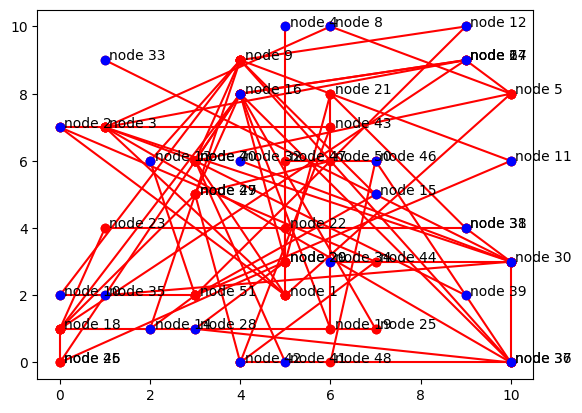

In [15]:
draw(rr0)

Old layering functions, for comparision.

In [67]:
def add_if_not(m: Dict, m1: Dict) -> Dict:
    nm = dict(m)
    for k, v in m1.items():
        if nm.get(k, None) is None:
            nm[k] = v
    return nm

def tube0(rr: RenderResult, roots: List[int], layers: List[List[int]]):
    new_layer: List[int] = roots[:WIDTH]
    new_roots: List[int] = roots[len(new_layer):] + [e[0] for gid in new_layer for e in rr.by_id(gid).edges]
    new_opts: Dict[int, Dict] = {
        goal_id: add_if_not(opts, {
            "row": len(layers) if goal_id in new_layer else None,
            "col": new_layer.index(goal_id) if goal_id in new_layer else None
        })
        for goal_id, opts in rr.node_opts.items()
    }
    
    return (RenderResult(rr.rows, node_opts=new_opts, select=rr.select, roots=rr.roots),
            new_roots,
            layers + [new_layer])

In [16]:
roots0 = list(rrr.roots)
layers0 = []

In [39]:
rr_0_1, roots_0_1, layers_0_1 = tube0(rr0, roots0, layers0)
roots_0_1, layers_0_1

([2, 3, 4, 5, 40], [[1]])

What happened here:
1. Node with id 1 is put to the first layer.
2. Nodes with ids 2, 3, 4, 5 and 40 are now candidates for the new layer. All of them are connected to node 1 with edges of lenght 1.

In [35]:
lengths_0_1 = {g: [1] for g in roots_0_1}
energy_0_1 = {g: sum([force(l, 1.0) for l in ls]) 
              for g, ls in lengths_0_1.items()}
lengths_0_1, energy_0_1

({2: [1], 3: [1], 4: [1], 5: [1], 40: [1]},
 {2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 40: 0.0})

At this step, there's no difference between all candidates. We could choose any of them for the next layer.

In [40]:
rr_0_2, roots_0_2, layers_0_2 = tube0(rr_0_1, roots_0_1, layers_0_1)
roots_0_2, layers_0_2

([5, 40, 43, 44, 6, 7, 8, 30, 37], [[1], [2, 3, 4]])

Technically, a difference starts to appear here. Edges for nodes 5 and 40 are grown by 1, and edges for all new nodes are short yet.

In [42]:
lengths_0_2 = {5: [2], 40: [2], 43: [1], 44: [1], 6: [1], 7: [1], 8: [1], 30: [1], 37: [1]}
energy_0_2 = {g: sum([force(l, 1.0) for l in ls]) 
              for g, ls in lengths_0_2.items()}
energy_0_2

{5: 1.0, 40: 1.0, 43: 0.0, 44: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 30: 0.0, 37: 0.0}

In the next iteration, we should prefer goals 5 and 40 over all others because their connections have the highest energy.

Now I should stop and introduce an algorithm to calculate it automatically. It's too boring to do it manually, and I also don't want to check whether there are additional edges between all goals.

In [95]:
def tube1(rr: RenderResult, roots: List[int], layers: List[List[int]]):
    new_layer: List[int] = roots[:WIDTH]
    new_roots: List[int] = roots[len(new_layer):] + \
                            [e[0] for gid in new_layer for e in rr.by_id(gid).edges]
    new_opts: Dict[int, Dict] = {
        goal_id: add_if_not(opts, {
            "row": len(layers) if goal_id in new_layer else None,
            "col": new_layer.index(goal_id) if goal_id in new_layer else None
        })
        for goal_id, opts in rr.node_opts.items()
    }
    # For simplicity, we would calculate length from a scratch every time
    # It's not optimal in production, but OK for algorithm crafting
    # 🐵 🐵 🐵 🐵 🐵 🐵 🐵 
    current_layer: int = len(layers) + 1
    already_layered: List[int] = [g for l in layers for g in l] + new_layer
    lengths: Dict[int, List[int]] = {
        g: [
            current_layer - new_opts[parent]["row"]
            for parent in already_layered
            if g in [e[0] for e in rr.by_id(parent).edges]
        ]
        for g in new_roots
    }
    # It should be optimized in the future!
    
    return (RenderResult(rr.rows, node_opts=new_opts, select=rr.select, roots=rr.roots),
            new_roots,
            lengths,
            layers + [new_layer])

## Re-render graph using the new function

### Step 1

In [96]:
rr_1_1, roots_1_1, lengths_1_1, layers_1_1 = tube1(rr0, roots0, layers0)
roots_1_1, lengths_1_1, layers_1_1

([2, 3, 4, 5, 40], {2: [1], 3: [1], 4: [1], 5: [1], 40: [1]}, [[1]])

Now we should calculate energies and re-sort `roots` variable from the highest to the lowest value of this parameter. As all lengths are currently equal each other, there's no difference from the old algorithm. But we could see it on the next steps.

In [97]:
energies_1_1 = [(g, sum([force(l, 1.0) for l in ls]))
                for g, ls in lengths_1_1.items()]
roots_1_1x = [t[0] for t in sorted(energies_1_1, key=itemgetter(1), reverse=True)]
energies_1_1, roots_1_1x, roots_1_1 == roots_1_1x

([(2, 0.0), (3, 0.0), (4, 0.0), (5, 0.0), (40, 0.0)], [2, 3, 4, 5, 40], True)

### Step 2

In [98]:
rr_1_2, roots_1_2, lengths_1_2, layers_1_2 = tube1(rr_1_1, roots_1_1x, layers_1_1)
roots_1_2, lengths_1_2, layers_1_2

([5, 40, 43, 44, 6, 7, 8, 30, 37],
 {5: [2], 40: [2], 43: [1], 44: [1], 6: [1], 7: [1], 8: [1], 30: [1], 37: [1]},
 [[1], [2, 3, 4]])

In [99]:
energies_1_2 = [(g, sum([force(l, 1.0) for l in ls]))
                for g, ls in lengths_1_2.items()]
roots_1_2x = [t[0] for t in sorted(energies_1_2, key=itemgetter(1), reverse=True)]
energies_1_2, roots_1_2x, roots_1_2x == roots_1_2

([(5, 1.0),
  (40, 1.0),
  (43, 0.0),
  (44, 0.0),
  (6, 0.0),
  (7, 0.0),
  (8, 0.0),
  (30, 0.0),
  (37, 0.0)],
 [5, 40, 43, 44, 6, 7, 8, 30, 37],
 True)

### Step 3

In [100]:
rr_1_3, roots_1_3, lengths_1_3, layers_1_3 = tube1(rr_1_2, roots_1_2x, layers_1_2)
roots_1_3, lengths_1_3, layers_1_3

([44, 6, 7, 8, 30, 37, 6, 7, 8, 39, 41],
 {44: [2],
  6: [2, 1],
  7: [2, 1],
  8: [2, 1],
  30: [2],
  37: [2],
  39: [1],
  41: [1]},
 [[1], [2, 3, 4], [5, 40, 43]])

Now it should be more interesting!

In [101]:
energies_1_3 = [(g, sum([force(l, 1.0) for l in ls]))
                for g, ls in lengths_1_3.items()]
roots_1_3x = [t[0] for t in sorted(energies_1_3, key=itemgetter(1), reverse=True)]
energies_1_3, roots_1_3x, roots_1_3x == roots_1_3

([(44, 1.0),
  (6, 1.0),
  (7, 1.0),
  (8, 1.0),
  (30, 1.0),
  (37, 1.0),
  (39, 0.0),
  (41, 0.0)],
 [44, 6, 7, 8, 30, 37, 39, 41],
 False)

Well, or not yet. Order is still the same. I've also found a potential bug in the "simple" version of algorightm. We have duplications in `roots_1_3`:

```
roots_1_3  = [44, 6, 7, 8, 30, 37, 6, 7, 8, 39, 41]
roots_1_3x = [44, 6, 7, 8, 30, 37,          39, 41]
```

Nevertheless, let's continue. It's still intriguing.

### Step 4

In [102]:
rr_1_4, roots_1_4, lengths_1_4, layers_1_4 = tube1(rr_1_3, roots_1_3x, layers_1_3)
roots_1_4, lengths_1_4, layers_1_4

([8, 30, 37, 39, 41, 9, 16],
 {8: [3, 2], 30: [3], 37: [3], 39: [2], 41: [2], 9: [1], 16: [1]},
 [[1], [2, 3, 4], [5, 40, 43], [44, 6, 7]])

Again, alredy sorted by energy. Okay, well!

In [103]:
energies_1_4 = [(g, sum([force(l, 1.0) for l in ls]))
                for g, ls in lengths_1_4.items()]
roots_1_4x = [t[0] for t in sorted(energies_1_4, key=itemgetter(1), reverse=True)]
energies_1_4, roots_1_4x, roots_1_4x == roots_1_4

([(8, 5.0), (30, 4.0), (37, 4.0), (39, 1.0), (41, 1.0), (9, 0.0), (16, 0.0)],
 [8, 30, 37, 39, 41, 9, 16],
 True)

Let's take a look at the current state of graph. There are several more layers to render.

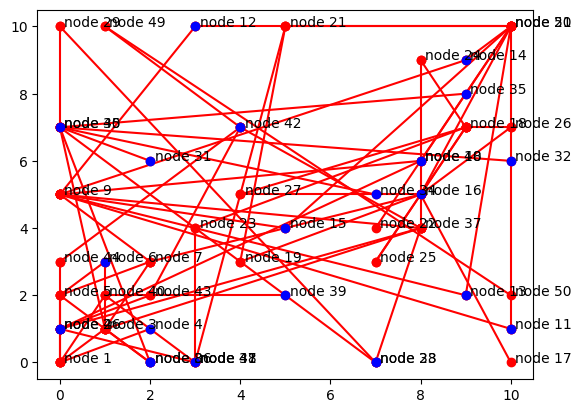

In [104]:
draw(rr_1_4)

### Step 5

In [105]:
rr_1_5, roots_1_5, lengths_1_5, layers_1_5 = tube1(rr_1_4, roots_1_4x, layers_1_4)
roots_1_5, lengths_1_5, layers_1_5

([39, 41, 9, 16, 31, 32, 33, 34, 35, 36, 9, 16, 28, 42, 46],
 {39: [3],
  41: [3],
  9: [2, 1],
  16: [2, 1],
  31: [1],
  32: [1],
  33: [1],
  34: [1],
  35: [1],
  36: [1],
  28: [1],
  42: [1],
  46: [1]},
 [[1], [2, 3, 4], [5, 40, 43], [44, 6, 7], [8, 30, 37]])

In [106]:
energies_1_5 = [(g, sum([force(l, 1.0) for l in ls]))
                for g, ls in lengths_1_5.items()]
roots_1_5x = [t[0] for t in sorted(energies_1_5, key=itemgetter(1), reverse=True)]
energies_1_5, roots_1_5x, roots_1_5x == roots_1_5

([(39, 4.0),
  (41, 4.0),
  (9, 1.0),
  (16, 1.0),
  (31, 0.0),
  (32, 0.0),
  (33, 0.0),
  (34, 0.0),
  (35, 0.0),
  (36, 0.0),
  (28, 0.0),
  (42, 0.0),
  (46, 0.0)],
 [39, 41, 9, 16, 31, 32, 33, 34, 35, 36, 28, 42, 46],
 False)

Again, duplications of 9 and 16. But a global order is still the same as without energy calculation.

### Step 6

In [107]:
rr_1_6, roots_1_6, lengths_1_6, layers_1_6 = tube1(rr_1_5, roots_1_5x, layers_1_5)
roots_1_6, lengths_1_6, layers_1_6

([16, 31, 32, 33, 34, 35, 36, 28, 42, 46, 10, 11, 12, 13, 14, 15],
 {16: [3, 2],
  31: [2],
  32: [2],
  33: [2],
  34: [2],
  35: [2],
  36: [2],
  28: [2],
  42: [2],
  46: [2],
  10: [1],
  11: [1],
  12: [1],
  13: [1],
  14: [1],
  15: [1]},
 [[1], [2, 3, 4], [5, 40, 43], [44, 6, 7], [8, 30, 37], [39, 41, 9]])

In [108]:
energies_1_6 = [(g, sum([force(l, 1.0) for l in ls]))
                for g, ls in lengths_1_6.items()]
roots_1_6x = [t[0] for t in sorted(energies_1_6, key=itemgetter(1), reverse=True)]
energies_1_6, roots_1_6x, roots_1_6x == roots_1_6

([(16, 5.0),
  (31, 1.0),
  (32, 1.0),
  (33, 1.0),
  (34, 1.0),
  (35, 1.0),
  (36, 1.0),
  (28, 1.0),
  (42, 1.0),
  (46, 1.0),
  (10, 0.0),
  (11, 0.0),
  (12, 0.0),
  (13, 0.0),
  (14, 0.0),
  (15, 0.0)],
 [16, 31, 32, 33, 34, 35, 36, 28, 42, 46, 10, 11, 12, 13, 14, 15],
 True)

### Step 7

In [109]:
rr_1_7, roots_1_7, lengths_1_7, layers_1_7 = tube1(rr_1_6, roots_1_6x, layers_1_6)
roots_1_7, lengths_1_7, layers_1_7

([33,
  34,
  35,
  36,
  28,
  42,
  46,
  10,
  11,
  12,
  13,
  14,
  15,
  17,
  18,
  19,
  20,
  24,
  25,
  26,
  27],
 {33: [3],
  34: [3],
  35: [3],
  36: [3],
  28: [3],
  42: [3],
  46: [3],
  10: [2],
  11: [2],
  12: [2],
  13: [2],
  14: [2],
  15: [2],
  17: [1],
  18: [1],
  19: [1],
  20: [1],
  24: [1],
  25: [1],
  26: [1],
  27: [1]},
 [[1],
  [2, 3, 4],
  [5, 40, 43],
  [44, 6, 7],
  [8, 30, 37],
  [39, 41, 9],
  [16, 31, 32]])

In [110]:
energies_1_7 = [(g, sum([force(l, 1.0) for l in ls]))
                for g, ls in lengths_1_7.items()]
roots_1_7x = [t[0] for t in sorted(energies_1_7, key=itemgetter(1), reverse=True)]
energies_1_7, roots_1_7x, roots_1_7x == roots_1_7

([(33, 4.0),
  (34, 4.0),
  (35, 4.0),
  (36, 4.0),
  (28, 4.0),
  (42, 4.0),
  (46, 4.0),
  (10, 1.0),
  (11, 1.0),
  (12, 1.0),
  (13, 1.0),
  (14, 1.0),
  (15, 1.0),
  (17, 0.0),
  (18, 0.0),
  (19, 0.0),
  (20, 0.0),
  (24, 0.0),
  (25, 0.0),
  (26, 0.0),
  (27, 0.0)],
 [33,
  34,
  35,
  36,
  28,
  42,
  46,
  10,
  11,
  12,
  13,
  14,
  15,
  17,
  18,
  19,
  20,
  24,
  25,
  26,
  27],
 True)

That's pretty cool. A simple and naive algorithm provides the same results as "complex" and "intellectual". Of course, I may have an error here :)

### Step 8

In [111]:
rr_1_8, roots_1_8, lengths_1_8, layers_1_8 = tube1(rr_1_7, roots_1_7x, layers_1_7)
roots_1_8, lengths_1_8, layers_1_8

([36, 28, 42, 46, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 24, 25, 26, 27],
 {36: [4],
  28: [4],
  42: [4],
  46: [4],
  10: [3],
  11: [3],
  12: [3],
  13: [3],
  14: [3],
  15: [3],
  17: [2],
  18: [2],
  19: [2],
  20: [2],
  24: [2],
  25: [2],
  26: [2],
  27: [2]},
 [[1],
  [2, 3, 4],
  [5, 40, 43],
  [44, 6, 7],
  [8, 30, 37],
  [39, 41, 9],
  [16, 31, 32],
  [33, 34, 35]])

In [112]:
energies_1_8 = [(g, sum([force(l, 1.0) for l in ls]))
                for g, ls in lengths_1_8.items()]
roots_1_8x = [t[0] for t in sorted(energies_1_8, key=itemgetter(1), reverse=True)]
energies_1_8, roots_1_8x, roots_1_8x == roots_1_8

([(36, 9.0),
  (28, 9.0),
  (42, 9.0),
  (46, 9.0),
  (10, 4.0),
  (11, 4.0),
  (12, 4.0),
  (13, 4.0),
  (14, 4.0),
  (15, 4.0),
  (17, 1.0),
  (18, 1.0),
  (19, 1.0),
  (20, 1.0),
  (24, 1.0),
  (25, 1.0),
  (26, 1.0),
  (27, 1.0)],
 [36, 28, 42, 46, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 24, 25, 26, 27],
 True)

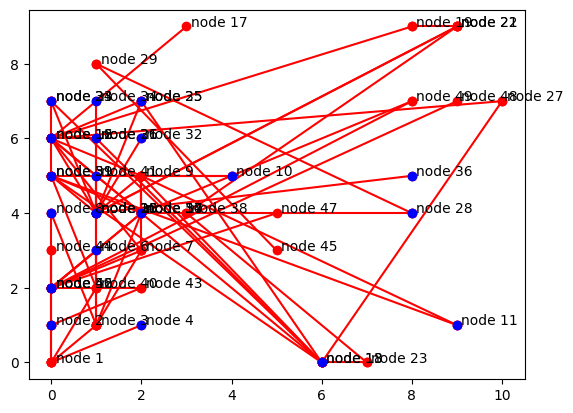

In [113]:
draw(rr_1_8)

### Step 9

In [114]:
rr_1_9, roots_1_9, lengths_1_9, layers_1_9 = tube1(rr_1_8, roots_1_8x, layers_1_8)
roots_1_9, lengths_1_9, layers_1_9

([46, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 24, 25, 26, 27, 29, 43, 44, 49],
 {46: [5],
  10: [4],
  11: [4],
  12: [4],
  13: [4],
  14: [4],
  15: [4],
  17: [3],
  18: [3],
  19: [3],
  20: [3],
  24: [3],
  25: [3],
  26: [3],
  27: [3],
  29: [1],
  43: [8, 1],
  44: [8, 1],
  49: [1]},
 [[1],
  [2, 3, 4],
  [5, 40, 43],
  [44, 6, 7],
  [8, 30, 37],
  [39, 41, 9],
  [16, 31, 32],
  [33, 34, 35],
  [36, 28, 42]])

In [115]:
energies_1_9 = [(g, sum([force(l, 1.0) for l in ls]))
                for g, ls in lengths_1_9.items()]
roots_1_9x = [t[0] for t in sorted(energies_1_9, key=itemgetter(1), reverse=True)]
energies_1_9, roots_1_9x, roots_1_9x == roots_1_9

([(46, 16.0),
  (10, 9.0),
  (11, 9.0),
  (12, 9.0),
  (13, 9.0),
  (14, 9.0),
  (15, 9.0),
  (17, 4.0),
  (18, 4.0),
  (19, 4.0),
  (20, 4.0),
  (24, 4.0),
  (25, 4.0),
  (26, 4.0),
  (27, 4.0),
  (29, 0.0),
  (43, 49.0),
  (44, 49.0),
  (49, 0.0)],
 [43, 44, 46, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 24, 25, 26, 27, 29, 49],
 False)

Nodes 43 and 44 are already placed. We should not populate them into `roots` value. Without them, ordering is still the same:

```
roots_1_9  = [        46, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 24, 25, 26, 27, 29, 43, 44, 49]
roots_1_9x = [43, 44, 46, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 24, 25, 26, 27, 29,         49]

### Step 10

In [116]:
rr_1_10, roots_1_10, lengths_1_10, layers_1_10 = tube1(rr_1_9, roots_1_9x, layers_1_9)
roots_1_10, lengths_1_10, layers_1_10

([10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 24, 25, 26, 27, 29, 49, 47, 48],
 {10: [5],
  11: [5],
  12: [5],
  13: [5],
  14: [5],
  15: [5],
  17: [4],
  18: [4],
  19: [4],
  20: [4],
  24: [4],
  25: [4],
  26: [4],
  27: [4],
  29: [2],
  49: [2],
  47: [1],
  48: [1]},
 [[1],
  [2, 3, 4],
  [5, 40, 43],
  [44, 6, 7],
  [8, 30, 37],
  [39, 41, 9],
  [16, 31, 32],
  [33, 34, 35],
  [36, 28, 42],
  [43, 44, 46]])

Wow, there are _things that should not be_! I've found what didn't expected actually: a bug in the "simple" placement algorithm. Nodes 43 and 44 exists in two layers at once. That's not fair. What are their "official" positions in the graph?

In [120]:
rr_1_10.node_opts[43], rr_1_10.node_opts[44]

({'row': 2, 'col': 2}, {'row': 3, 'col': 0})

### Next steps

So... looks like we could improve rendering results "simply" by avoiding duplications? Let's roll few more iterations and check for how many duplication would appear in `layers`. Do not re-sort `roots` anymore.

In [124]:
rr_1_11, roots_1_11, lengths_1_11, layers_1_11 = tube1(rr_1_10, roots_1_10, layers_1_10)
rr_1_12, roots_1_12, lengths_1_12, layers_1_12 = tube1(rr_1_11, roots_1_11, layers_1_11)
rr_1_13, roots_1_13, lengths_1_13, layers_1_13 = tube1(rr_1_12, roots_1_12, layers_1_12)
roots_1_13, lengths_1_13, layers_1_13

([20, 24, 25, 26, 27, 29, 49, 47, 48, 51, 51, 51, 51, 51, 51, 23, 21],
 {20: [7],
  24: [7],
  25: [7],
  26: [7],
  27: [7],
  29: [5],
  49: [5],
  47: [4],
  48: [4],
  51: [3, 3, 3, 2, 2, 2],
  23: [1],
  21: [1]},
 [[1],
  [2, 3, 4],
  [5, 40, 43],
  [44, 6, 7],
  [8, 30, 37],
  [39, 41, 9],
  [16, 31, 32],
  [33, 34, 35],
  [36, 28, 42],
  [43, 44, 46],
  [10, 11, 12],
  [13, 14, 15],
  [17, 18, 19]])

No new duplications - but a new candidate for sorting. What goal has more energy: 47/48 with `[4]` or 51 with `[3, 3, 3, 2, 2, 2]`?

In [125]:
energies_1_13 = [(g, sum([force(l, 1.0) for l in ls]))
                for g, ls in lengths_1_13.items()]
roots_1_13x = [t[0] for t in sorted(energies_1_13, key=itemgetter(1), reverse=True)]
energies_1_13, roots_1_13x, roots_1_13x == roots_1_13

([(20, 36.0),
  (24, 36.0),
  (25, 36.0),
  (26, 36.0),
  (27, 36.0),
  (29, 16.0),
  (49, 16.0),
  (47, 9.0),
  (48, 9.0),
  (51, 15.0),
  (23, 0.0),
  (21, 0.0)],
 [20, 24, 25, 26, 27, 29, 49, 51, 47, 48, 23, 21],
 False)

Goal 51 won two positions. Well...

### Step 14

In [126]:
rr_1_14, roots_1_14, lengths_1_14, layers_1_14 = tube1(rr_1_13, roots_1_13x, layers_1_13)
roots_1_14, lengths_1_14, layers_1_14

([26, 27, 29, 49, 51, 47, 48, 23, 21, 21, 22, 18, 18],
 {26: [8],
  27: [8],
  29: [6],
  49: [6],
  51: [4, 4, 4, 3, 3, 3],
  47: [5],
  48: [5],
  23: [2],
  21: [2, 1],
  22: [1],
  18: [8, 1, 1]},
 [[1],
  [2, 3, 4],
  [5, 40, 43],
  [44, 6, 7],
  [8, 30, 37],
  [39, 41, 9],
  [16, 31, 32],
  [33, 34, 35],
  [36, 28, 42],
  [43, 44, 46],
  [10, 11, 12],
  [13, 14, 15],
  [17, 18, 19],
  [20, 24, 25]])

In [127]:
energies_1_14 = [(g, sum([force(l, 1.0) for l in ls]))
                for g, ls in lengths_1_14.items()]
roots_1_14x = [t[0] for t in sorted(energies_1_14, key=itemgetter(1), reverse=True)]
energies_1_14, roots_1_14x, roots_1_14x == roots_1_14

([(26, 49.0),
  (27, 49.0),
  (29, 25.0),
  (49, 25.0),
  (51, 39.0),
  (47, 16.0),
  (48, 16.0),
  (23, 1.0),
  (21, 1.0),
  (22, 0.0),
  (18, 49.0)],
 [26, 27, 18, 51, 29, 49, 47, 48, 23, 21, 22],
 False)

Goal 51 won 2 more positions. But that's an another interesting point: a goal 18 appears in `roots` again (it was already placed at layer 12).

In [129]:
rr_1_14.node_opts[18]

{'row': 12, 'col': 1}

### Step 15

In [130]:
rr_1_15, roots_1_15, lengths_1_15, layers_1_15 = tube1(rr_1_14, roots_1_14x, layers_1_14)
roots_1_15, lengths_1_15, layers_1_15

([51, 29, 49, 47, 48, 23, 21, 22, 18, 18, 23],
 {51: [5, 5, 5, 4, 4, 4],
  29: [7],
  49: [7],
  47: [6],
  48: [6],
  23: [3, 3],
  21: [3, 2],
  22: [2],
  18: [9, 2, 2, 1, 1]},
 [[1],
  [2, 3, 4],
  [5, 40, 43],
  [44, 6, 7],
  [8, 30, 37],
  [39, 41, 9],
  [16, 31, 32],
  [33, 34, 35],
  [36, 28, 42],
  [43, 44, 46],
  [10, 11, 12],
  [13, 14, 15],
  [17, 18, 19],
  [20, 24, 25],
  [26, 27, 18]])

And again, goal 18!

In [131]:
energies_1_15 = [(g, sum([force(l, 1.0) for l in ls]))
                for g, ls in lengths_1_15.items()]
roots_1_15x = [t[0] for t in sorted(energies_1_15, key=itemgetter(1), reverse=True)]
energies_1_15, roots_1_15x, roots_1_15x == roots_1_15

([(51, 75.0),
  (29, 36.0),
  (49, 36.0),
  (47, 25.0),
  (48, 25.0),
  (23, 8.0),
  (21, 5.0),
  (22, 1.0),
  (18, 66.0)],
 [51, 18, 29, 49, 47, 48, 23, 21, 22],
 False)

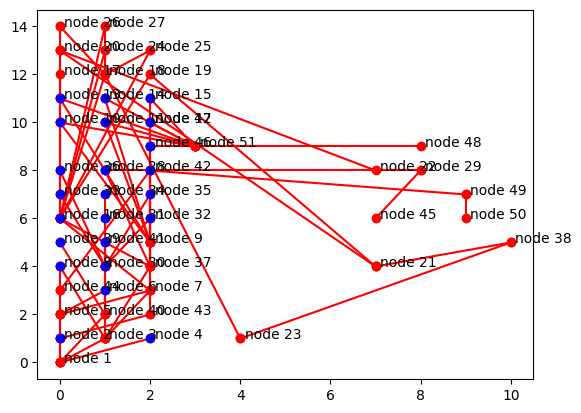

In [132]:
draw(rr_1_15)